In [1]:

from scipy.integrate import ode
import SundialsPy as SP
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, List, Dict, Any, Optional
import os
from datetime import datetime
import time
from tqdm import tqdm
from utils import *

In [2]:
fuel = 'nc12h26:1.0'
oxidizer = 'N2:3.76, O2:1.0'
fuel_species = 'nc12h26'
mechanism_file = 'large_mechanism/n-dodecane.yaml'
rtol = 1e-6
atol = 1e-8

In [3]:
def reset_gas(temperature=600, pressure=101325, phi=1):
    gas = ct.Solution(mechanism_file)
    gas.set_equivalence_ratio(phi, fuel, 'O2:1, N2:3.76')
    gas.TPX = temperature, pressure, gas.X
    y0 = get_initial_state(gas)
    return gas, y0

In [4]:
implicit_solvers = [SP.arkode.ButcherTable.ARK2_DIRK_3_1_2, SP.arkode.ButcherTable.ESDIRK325L2SA_5_2_3, 
                    SP.arkode.ButcherTable.TRBDF2_3_3_2, SP.arkode.ButcherTable.ESDIRK436L2SA_6_3_4, SP.arkode.ButcherTable.ESDIRK43I6L2SA_6_3_4, 
                    SP.arkode.ButcherTable.QESDIRK436L2SA_6_3_4, 
                    SP.arkode.ButcherTable.CASH_5_2_4, SP.arkode.ButcherTable.CASH_5_3_4, SP.arkode.ButcherTable.SDIRK_5_3_4, 
                    SP.arkode.ButcherTable.ARK436L2SA_DIRK_6_3_4, SP.arkode.ButcherTable.ESDIRK437L2SA_7_3_4, SP.arkode.ButcherTable.ARK437L2SA_DIRK_7_3_4]

print(f"Number of implicit solvers = {len(implicit_solvers)}")

explicit_solvers = [SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3,
        SP.arkode.ButcherTable.ARK324L2SA_ERK_4_2_3, SP.arkode.ButcherTable.ZONNEVELD_5_3_4,
        SP.arkode.ButcherTable.ARK436L2SA_ERK_6_3_4, SP.arkode.ButcherTable.ARK437L2SA_ERK_7_3_4,
        SP.arkode.ButcherTable.ARK548L2SA_ERK_8_4_5,
        SP.arkode.ButcherTable.VERNER_8_5_6,
        SP.arkode.ButcherTable.FEHLBERG_13_7_8]

print(f"Number of explicit solvers = {len(explicit_solvers)}")

Number of implicit solvers = 12
Number of explicit solvers = 9


In [5]:
solver_to_run = [SP.arkode.ButcherTable.ARK2_DIRK_3_1_2, SP.arkode.ButcherTable.TRBDF2_3_3_2, SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3]

print(f"Number of solvers to plot = {len(solver_to_run)}")

Number of solvers to plot = 4


In [40]:
temperature = 1000
pressure = 101325
phi = 1
gas, y0 = reset_gas(temperature, pressure, phi)
t0 = 0.0
end_time = 6e-2
timestep = 1e-6
species_to_track = gas.species_names
fuel = 'nc12h26'
time_limit = 1200.0
table_id = SP.arkode.ButcherTable.HEUN_EULER_2_1_2


In [10]:
# Define parameters for different runs
run_params = [
    ('reference', 1e-12, 1e-10),
    ('bdf_results_high', 1e-8, 1e-10), 
    ('bdf_results_low', 1e-6, 1e-8)
]

bdf_results = {}

# Loop through parameters and run experiments
for result_name, rtol, atol in run_params:
    gas, y0 = reset_gas(temperature, pressure, phi)
    method = 'cvode_bdf'
    
    results = run_integration_experiment(
                method, gas, y0, t0, end_time, timestep,
                rtol, atol, species_to_track,
                fuel, pressure=gas.P,
                time_limit=time_limit,
                table_id=None
            )
    
    bdf_results[result_name] = results
    

Running cvode_bdf-None with rtol=1e-12 and atol=1e-10: 100%|█████████▉| 0.05999900000003935/0.06 [09:37<00:00, 14418.85s/it, step=59999, temperature=2589.2K, cpu_time=3.51e-03s, total_cpu_time=1.78e+02s] /home/elo/miniforge3/envs/sundialEnv/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Running cvode_bdf-None with rtol=1e-12 and atol=1e-10: 100%|██████████| 0.06000000000003935/0.06 [09:37<00:00, 9626.93s/it, step=60000, temperature=2589.2K, cpu_time=3.59e-03s, total_cpu_time=1.78e+02s] 
Running cvode_bdf-None with rtol=1e-08 and atol=1e-10:  82%|████████▏ | 0.04944000000002879/0.06 [10:00<02:08, 12136.19s/it, step=49439, temperature=2589.2K, cpu_time=1.33e-03s, total_cpu_time=1.16e+02s] 


Time limit of 600.0s exceeded after 49439 steps


Running cvode_bdf-None with rtol=1e-06 and atol=1e-08: 100%|██████████| 0.06000000000003935/0.06 [07:18<00:00, 7308.72s/it, step=60000, temperature=2590.8K, cpu_time=2.96e-03s, total_cpu_time=1.62e+02s]  


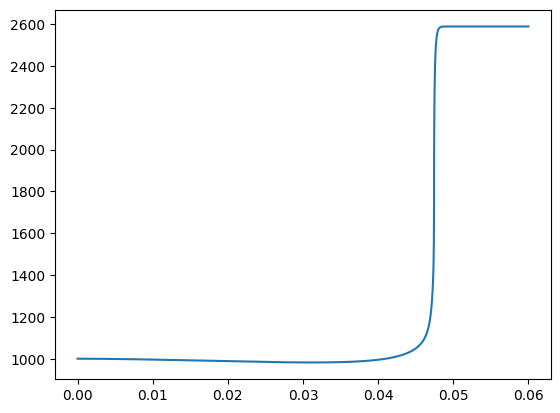

In [11]:
plt.plot(bdf_results['reference']['times'], bdf_results['reference']['temperatures'], label='Reference')

In [12]:
pre_ignition_end_idx, ignition_start_idx, ignition_end_idx = detect_ignition_regions(bdf_results['reference']['temperatures'], bdf_results['reference']['times'])

In [13]:
print(f"pre-ignition end index: {pre_ignition_end_idx}")
print(f"ignition start index: {ignition_start_idx}")
print(f"ignition end index: {ignition_end_idx}")


pre-ignition end index: 47345
ignition start index: 47346
ignition end index: 47579


In [14]:
method_dict = {
    0: ('arkode_erk', 1e-6, 1e-8, SP.arkode.ButcherTable.HEUN_EULER_2_1_2),
    10000: ('cvode_bdf', 1e-6, 1e-8, None),
}

rk_bdf_results = run_integration_with_switching(method_dict, gas, y0, t0, end_time, timestep, species_to_track, fuel, pressure, time_limit)



  0%|          | 0.00010099999999999981/0.06 [00:00<01:54, 1912.16s/it, step=101, temperature=1000.0K, cpu_time=9.73e-04s, total_cpu_time=1.07e-01s]

Switching to arkode_erk at step 0 with rtol=1e-06 and atol=1e-08 and table_id=ButcherTable.HEUN_EULER_2_1_2


 17%|█▋        | 0.010030999999999082/0.06 [00:32<04:21, 5239.82s/it, step=10030, temperature=995.8K, cpu_time=2.91e-03s, total_cpu_time=1.84e+01s] 

Switching to cvode_bdf at step 10000 with rtol=1e-06 and atol=1e-08 and table_id=None


100%|██████████| 0.06000000000003935/0.06 [07:46<00:00, 7782.37s/it, step=60000, temperature=2591.9K, cpu_time=2.81e-03s, total_cpu_time=1.57e+02s]  


In [ ]:
pure_rk_results = run_integration_experiment(
                method, gas, y0, t0, end_time, timestep,
                rtol, atol, species_to_track,
                fuel, pressure=gas.P,
                time_limit=time_limit,
                table_id=table_id
            )

In [ ]:
solvers_results_high = {}
for table_id in solver_to_run:
    if table_id in implicit_solvers:
        method = 'arkode_dirk'
    else:
        method = 'arkode_erk'
    gas, y0 = reset_gas(temperature, pressure, phi)
    rtol, atol = 1e-8, 1e-10

    results = run_integration_experiment(
                method, gas, y0, t0, end_time, timestep,
                rtol, atol, species_to_track,
                fuel, pressure=gas.P,
                time_limit=time_limit,
                table_id=table_id
            )
    solvers_results_high[table_id] = results


In [ ]:
solvers_results_low = {}
for table_id in solver_to_run:
    if table_id in implicit_solvers:
        method = 'arkode_dirk'
    else:
        method = 'arkode_erk'
    gas, y0 = reset_gas(temperature, pressure, phi)
    rtol, atol = 1e-6, 1e-8

    results = run_integration_experiment(
                method, gas, y0, t0, end_time, timestep,
                rtol, atol, species_to_track,
                fuel, pressure=gas.P,
                time_limit=time_limit,
                table_id=table_id
            )
    solvers_results_low[table_id] = results

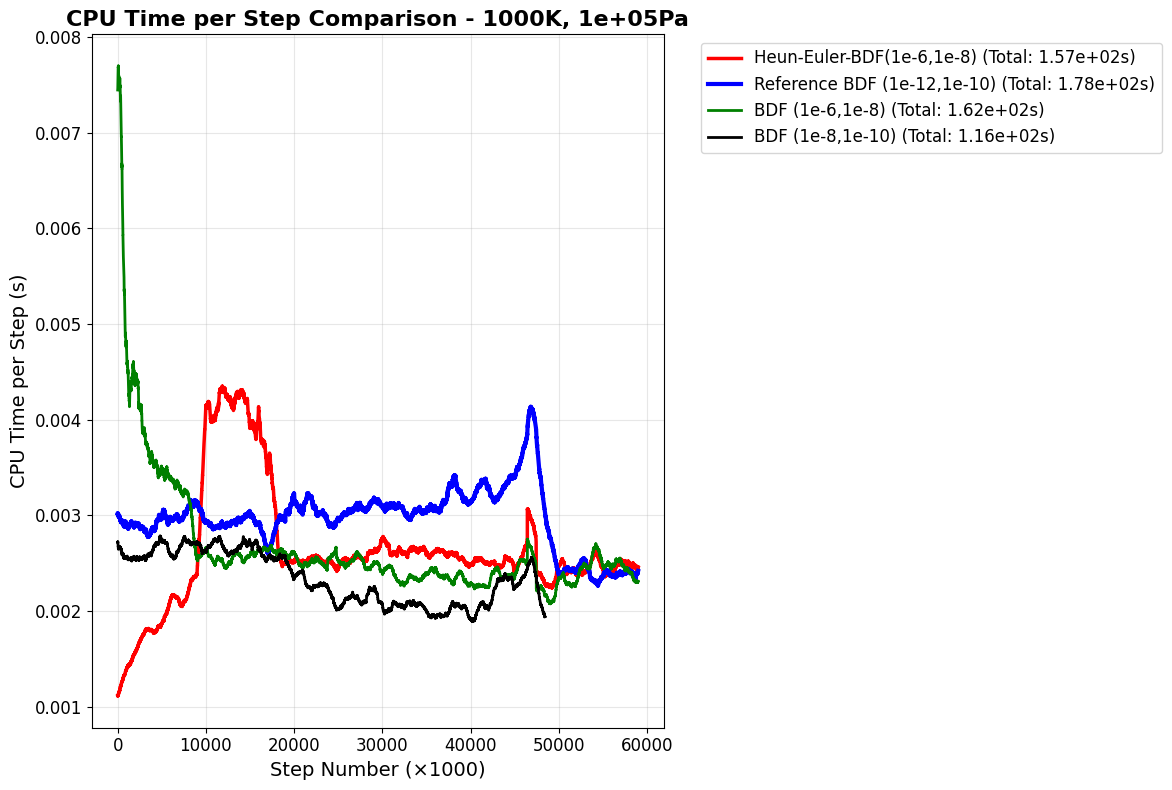

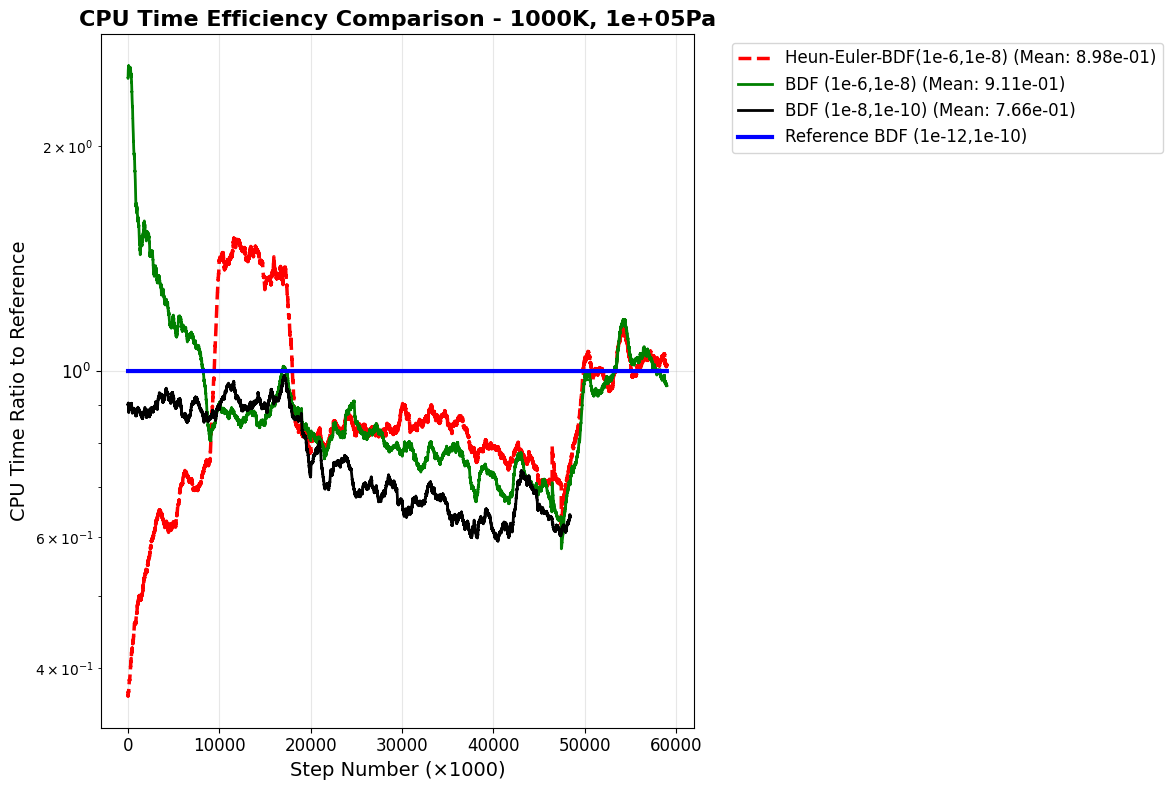

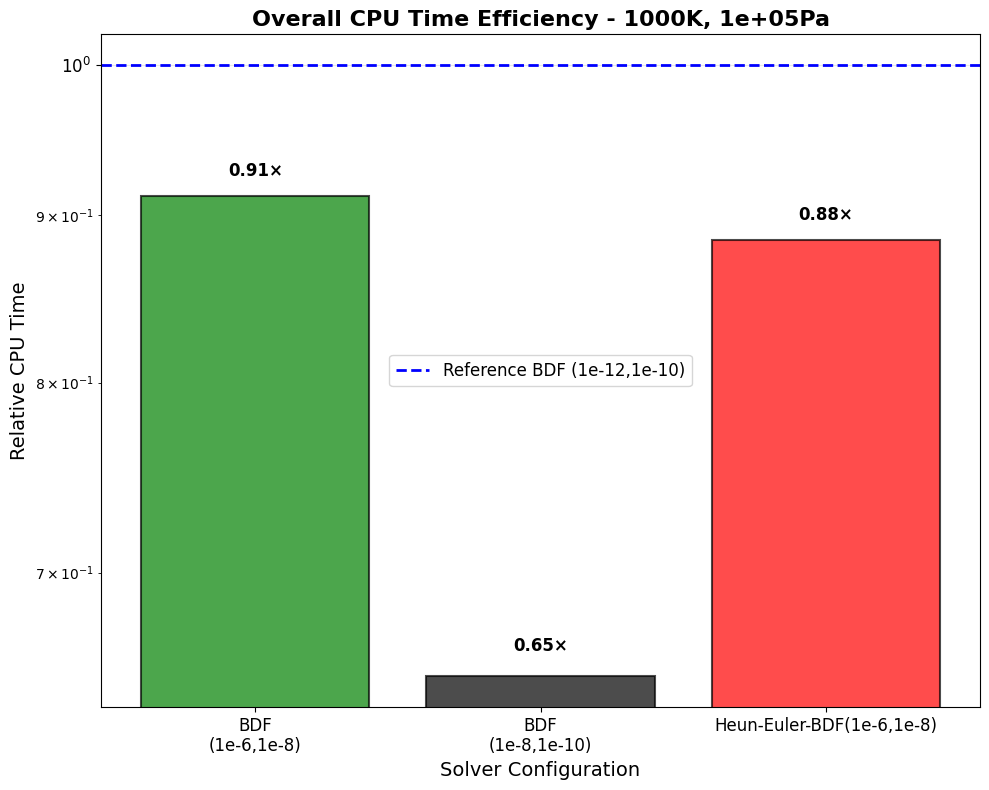

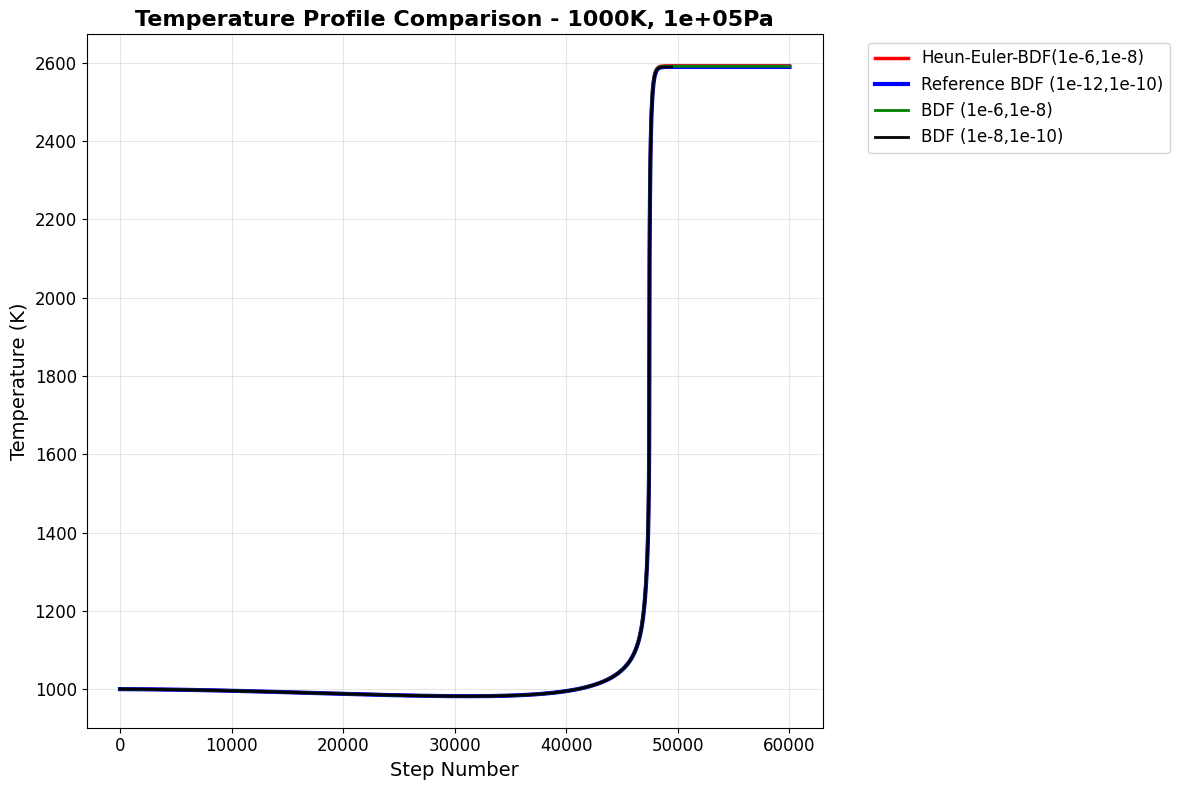

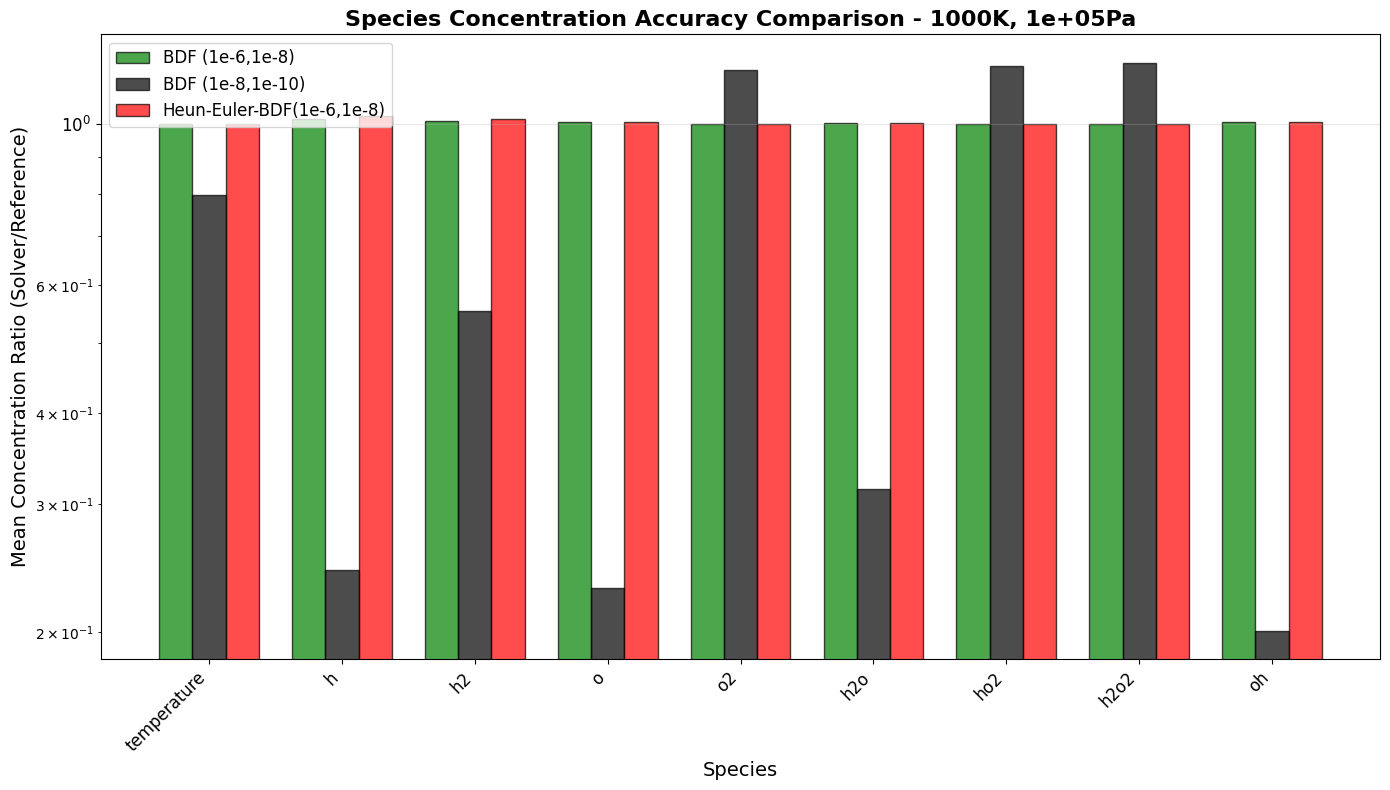

In [41]:
def compare_solver_performance(bdf_results, comparison_results, comparison_name="Comparison", 
                             temperature=None, pressure=None, species_to_track=None):
    """
    Create comprehensive performance comparison plots between BDF reference and comparison solver.
    
    Args:
        bdf_results: Dictionary containing BDF solver results with keys:
                    - 'reference': high precision reference solution
                    - 'bdf_results_low': low tolerance BDF results  
                    - 'bdf_results_high': high tolerance BDF results
        comparison_results: Results dictionary for the comparison solver
        comparison_name: Name for the comparison solver in plots
        temperature: Temperature for plot titles
        pressure: Pressure for plot titles
        species_to_track: List of species for analysis
    """
    
    # Define plotting parameters
    line_styles = ['-', '--', '-.', ':']
    colors = ['red', 'blue', 'green', 'black', 'purple', 'orange']
    
    # Helper function for running average
    def running_average_forward(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    # 1. CPU Time per Step Comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(running_average_forward(comparison_results['cpu_times'], 1000),
            label=f"{comparison_name} (Total: {np.sum(comparison_results['cpu_times']):.2e}s)",
            linestyle='-', linewidth=2.5, color='red')
    
    ax.plot(running_average_forward(bdf_results['reference']['cpu_times'], 1000),
            label=f"Reference BDF (1e-12,1e-10) (Total: {np.sum(bdf_results['reference']['cpu_times']):.2e}s)",
            linestyle='-', linewidth=3, color='blue')
    
    ax.plot(running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000),
            label=f"BDF (1e-6,1e-8) (Total: {np.sum(bdf_results['bdf_results_low']['cpu_times']):.2e}s)",
            linestyle='-', linewidth=2, color='green')
    
    ax.plot(running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000),
            label=f"BDF (1e-8,1e-10) (Total: {np.sum(bdf_results['bdf_results_high']['cpu_times']):.2e}s)",
            linestyle='-', linewidth=2, color='black')
    
    ax.set_xlabel('Step Number (×1000)', fontsize=14)
    ax.set_ylabel('CPU Time per Step (s)', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    title = f'CPU Time per Step Comparison'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. CPU Time Ratio to Reference
    fig, ax = plt.subplots(figsize=(12, 8))
    
    reference_times = running_average_forward(bdf_results['reference']['cpu_times'], 1000)
    
    # Comparison solver ratio
    comp_times = running_average_forward(comparison_results['cpu_times'], 1000)
    comp_ratio = comp_times / reference_times[:len(comp_times)]
    ax.plot(comp_ratio, label=f"{comparison_name} (Mean: {np.mean(comp_ratio):.2e})",
            linestyle='--', linewidth=2.5, color='red')
    
    # BDF ratios
    bdf_low_times = running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000)
    bdf_low_ratio = bdf_low_times / reference_times[:len(bdf_low_times)]
    ax.plot(bdf_low_ratio, label=f'BDF (1e-6,1e-8) (Mean: {np.mean(bdf_low_ratio):.2e})',
            linestyle='-', linewidth=2, color='green')
    
    bdf_high_times = running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000)
    bdf_high_ratio = bdf_high_times / reference_times[:len(bdf_high_times)]
    ax.plot(bdf_high_ratio, label=f'BDF (1e-8,1e-10) (Mean: {np.mean(bdf_high_ratio):.2e})',
            linestyle='-', linewidth=2, color='black')
    
    # Reference line
    ax.plot(np.ones_like(reference_times), label='Reference BDF (1e-12,1e-10)',
            linestyle='-', linewidth=3, color='blue')
    
    ax.set_yscale('log')
    ax.set_xlabel('Step Number (×1000)', fontsize=14)
    ax.set_ylabel('CPU Time Ratio to Reference', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    title = f'CPU Time Efficiency Comparison'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Overall CPU Time Bar Chart
    fig, ax = plt.subplots(figsize=(10, 8))
    
    reference_time = np.sum(bdf_results['reference']['cpu_times'])
    
    solver_names = ['BDF\n(1e-6,1e-8)', 'BDF\n(1e-8,1e-10)', comparison_name]
    relative_times = [
        np.sum(bdf_results['bdf_results_low']['cpu_times']) / reference_time,
        np.sum(bdf_results['bdf_results_high']['cpu_times']) / reference_time,
        np.sum(comparison_results['cpu_times']) / reference_time
    ]
    
    bars = ax.bar(solver_names, relative_times, 
                  color=['green', 'black', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, relative_times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.2f}×', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.axhline(y=1.0, color='blue', linestyle='--', linewidth=2, label='Reference BDF (1e-12,1e-10)')
    ax.set_ylabel('Relative CPU Time', fontsize=14)
    ax.set_xlabel('Solver Configuration', fontsize=14)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    
    title = f'Overall CPU Time Efficiency'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Temperature Profiles
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(comparison_results['temperatures'], label=comparison_name,
            linestyle='-', linewidth=2.5, color='red')
    ax.plot(bdf_results['reference']['temperatures'], label='Reference BDF (1e-12,1e-10)',
            linestyle='-', linewidth=3, color='blue')
    ax.plot(bdf_results['bdf_results_low']['temperatures'], label='BDF (1e-6,1e-8)',
            linestyle='-', linewidth=2, color='green')
    ax.plot(bdf_results['bdf_results_high']['temperatures'], label='BDF (1e-8,1e-10)',
            linestyle='-', linewidth=2, color='black')
    
    ax.set_xlabel('Step Number', fontsize=14)
    ax.set_ylabel('Temperature (K)', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)
    
    title = f'Temperature Profile Comparison'
    if temperature and pressure:
        title += f' - {temperature}K, {pressure:.0e}Pa'
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Species Concentration Analysis
    if species_to_track:
        def calculate_maximum_species_conc(data, ref_data, species_names):
            max_concentrations = {}
            for specie in species_names:
                if specie == 'temperature':
                    max_conc = np.mean(data['temperatures'])
                    ref_max_conc = np.mean(ref_data['temperatures'])
                else:
                    max_conc = np.mean(data['species_profiles'][specie])
                    ref_max_conc = np.mean(ref_data['species_profiles'][specie])
                max_concentrations[specie] = (max_conc, ref_max_conc)
            return max_concentrations
        
        species_to_plot = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
        
        # Calculate concentration ratios
        bdf_max_conc_low = calculate_maximum_species_conc(
            bdf_results['bdf_results_low'], bdf_results['reference'], species_to_plot)
        bdf_max_conc_high = calculate_maximum_species_conc(
            bdf_results['bdf_results_high'], bdf_results['reference'], species_to_plot)
        comp_max_conc = calculate_maximum_species_conc(
            comparison_results, bdf_results['reference'], species_to_plot)
        
        # Create species concentration ratio plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        x_positions = np.arange(len(species_to_plot))
        width = 0.25
        
        # Calculate ratios
        bdf_ratios_low = [bdf_max_conc_low[sp][0] / bdf_max_conc_low[sp][1] for sp in species_to_plot]
        bdf_ratios_high = [bdf_max_conc_high[sp][0] / bdf_max_conc_high[sp][1] for sp in species_to_plot]
        comp_ratios = [comp_max_conc[sp][0] / comp_max_conc[sp][1] for sp in species_to_plot]
        
        # Create grouped bar chart
        ax.bar(x_positions - width, bdf_ratios_low, width, label='BDF (1e-6,1e-8)', 
               color='green', alpha=0.7, edgecolor='black')
        ax.bar(x_positions, bdf_ratios_high, width, label='BDF (1e-8,1e-10)', 
               color='black', alpha=0.7, edgecolor='black')
        ax.bar(x_positions + width, comp_ratios, width, label=comparison_name, 
               color='red', alpha=0.7, edgecolor='black')
        
        ax.set_xlabel('Species', fontsize=14)
        ax.set_ylabel('Mean Concentration Ratio (Solver/Reference)', fontsize=14)
        ax.set_yscale('log')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(species_to_plot, rotation=45, ha='right', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(labelsize=12)
        
        title = f'Species Concentration Accuracy Comparison'
        if temperature and pressure:
            title += f' - {temperature}K, {pressure:.0e}Pa'
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# Call the function with the existing data
compare_solver_performance(bdf_results, rk_bdf_results, "Heun-Euler-BDF(1e-6,1e-8)", 
                         temperature=temperature, pressure=pressure, 
                         species_to_track=species_to_track)


In [ ]:
# # PLOT THE CPU TIME OF THE IMPLICIT SOLVERS IN A 2x2 GRID
# line_styles = ['-', '--', '-.', ':'] * 10  # Repeat basic line styles
# colors = [ 'purple', 'orange', 'brown', 'pink',  'cyan', 'magenta', 'lime', 'teal', 'navy', 'gray', 'olive','maroon', 'gold', 'silver', 'indigo', 'turquoise']

# # Create figure with 2x2 subplots sharing x and y axes
# fig, ax = plt.subplots(figsize=(15, 10), dpi=200)

# # Plot each group in its own subplot
# for i, table_id in enumerate(solver_to_run):
#     # if table_id in solver_to_exclude:
#     #     continue
#     data = solvers_results_high[table_id]
#     if len(data['cpu_times']) < 100:
#         continue
#     ax.plot(
#         running_average_forward(data['cpu_times'], 1000),
#         label=f"{str(table_id)} high - {np.sum(data['cpu_times']):.2e}",
#         linestyle='--',
#         linewidth=2,
#         color=colors[i]
#     )
#     data = solvers_results_low[table_id]
#     ax.plot(
#         running_average_forward(data['cpu_times'], 1000),
#         label=f"{str(table_id)} low - {np.sum(data['cpu_times']):.2e}",
#         linestyle='-',
#         linewidth=2,
#         color=colors[i]
#     )
# ax.plot(
#     running_average_forward(bdf_results['reference']['cpu_times'], 1000    ),
#     label=f'Reference(1e-12,1e-10) - {np.sum(bdf_results['reference']['cpu_times']):.2e}',
#     linestyle='-',
#     linewidth=3,
#     color='red'
# )

# ax.plot(
#     running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000),
#     label=f'BDF(1e-6,1e-8) - {np.sum(bdf_results['bdf_results_low']['cpu_times']):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='blue'
# )

# ax.plot(
#     running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000),
#     label=f'BDF(1e-8,1e-10) - {np.sum(bdf_results['bdf_results_high']['cpu_times']):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='green'
# )
# # ax.set_title(f'Solvers {subplot_idx*6 + 1}-{min((subplot_idx+1)*6, 25)}')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

# # # Set common labels
# # fig.text(0.5, 0.04, 'Step Number', ha='center', va='center')
# # fig.text(0.06, 0.5, 'CPU Time (s)', ha='center', va='center', rotation='vertical')
# fig.suptitle(f'CPU Time per Step for Different Implicit Solvers - {temperature}K - {pressure}Pa', fontsize=16)

# plt.tight_layout()
# plt.show()


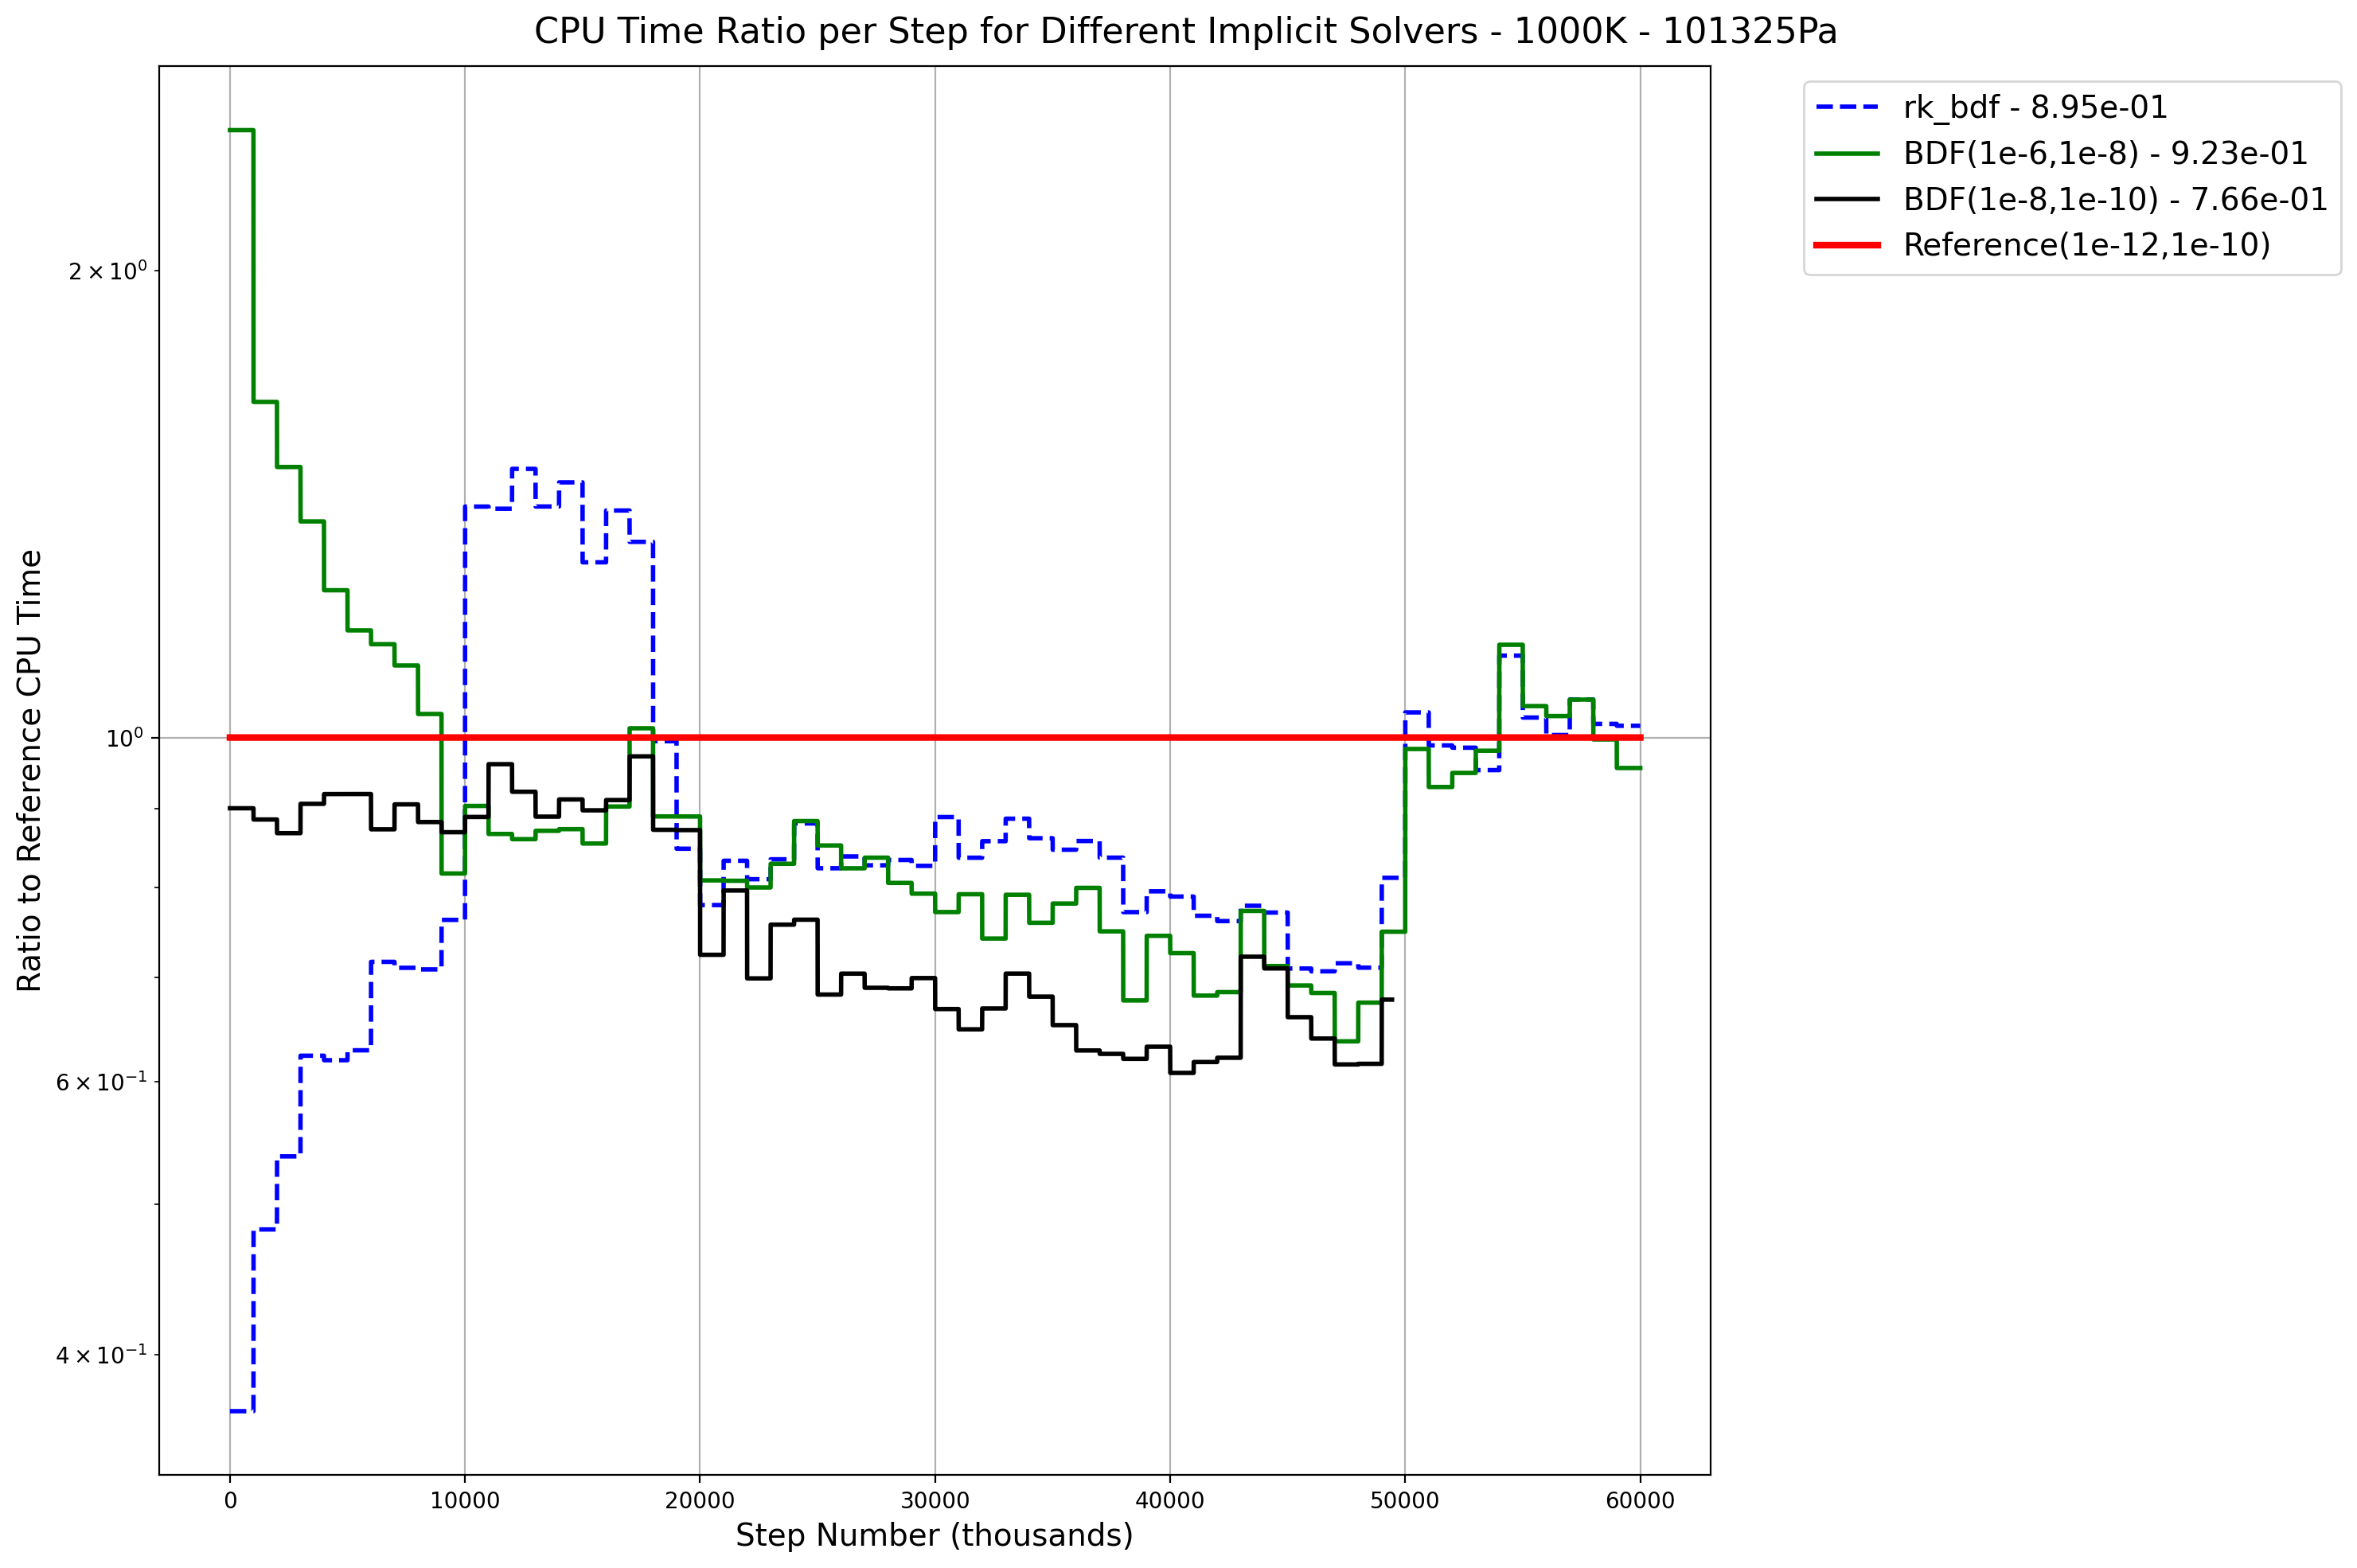

In [ ]:
# # PLOT THE CPU TIME OF THE IMPLICIT SOLVERS IN A 2x2 GRID
# line_styles = ['-', '--', '-.', ':'] * 10  # Repeat basic line styles
# colors = [ 'purple', 'orange', 'brown', 'pink',  'cyan', 'magenta', 'lime', 'teal', 'navy', 'gray', 'olive','maroon', 'gold', 'silver', 'indigo', 'turquoise']

# # Create figure with 2x2 subplots sharing x and y axes
# fig, ax = plt.subplots(figsize=(15, 10), dpi=200)

# # Get reference data
# reference_times = running_average_forward(bdf_results['reference']['cpu_times'], 1000)

# # Plot each group in its own subplot
# for i, table_id in enumerate(solver_to_run):
#     # High tolerance results
#     data = solvers_results_high[table_id]
#     solver_times = running_average_forward(data['cpu_times'], 1000)
#     if len(solver_times) < 100:
#         continue
#     ratio = solver_times / reference_times[:len(solver_times)]
#     ax.plot(
#         ratio,
#         label=f"{str(table_id)} high - {np.mean(ratio):.2e}",
#         linestyle='--',
#         linewidth=2,
#         color=colors[i]
#     )
    
#     # Low tolerance results
#     data = solvers_results_low[table_id]
#     solver_times = running_average_forward(data['cpu_times'], 1000)
#     ratio = solver_times / reference_times[:len(solver_times)]
#     ax.plot(
#         ratio,
#         label=f"{str(table_id)} low - {np.mean(ratio):.2e}",
#         linestyle='-',
#         linewidth=2,
#         color=colors[i]
#     )

# # Plot BDF ratios
# bdf_low_times = running_average_forward(bdf_results['bdf_results_low']['cpu_times'], 1000)
# ratio = bdf_low_times / reference_times[:len(bdf_low_times)]
# ax.plot(
#     ratio,
#     label=f'BDF(1e-6,1e-8) - {np.mean(ratio):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='blue'
# )

# bdf_high_times = running_average_forward(bdf_results['bdf_results_high']['cpu_times'], 1000)
# ratio = bdf_high_times / reference_times[:len(bdf_high_times)]
# ax.plot(
#     ratio,
#     label=f'BDF(1e-8,1e-10) - {np.mean(ratio):.2e}',
#     linestyle='-',
#     linewidth=2,
#     color='green'
# )

# # Plot reference ratio (always 1.0)
# ax.plot(
#     np.ones_like(reference_times),
#     label='Reference(1e-12,1e-10)',
#     linestyle='-',
#     linewidth=3,
#     color='red'
# )

# ax.set_yscale('log')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
# ax.set_ylabel('Ratio to Reference CPU Time', fontsize=14)
# ax.set_xlabel('Step Number (thousands)', fontsize=14)
# ax.grid(True)

# fig.suptitle(f'CPU Time Ratio per Step for Different Implicit Solvers - {temperature}K - {pressure}Pa', fontsize=16)

# plt.tight_layout()
# plt.show()

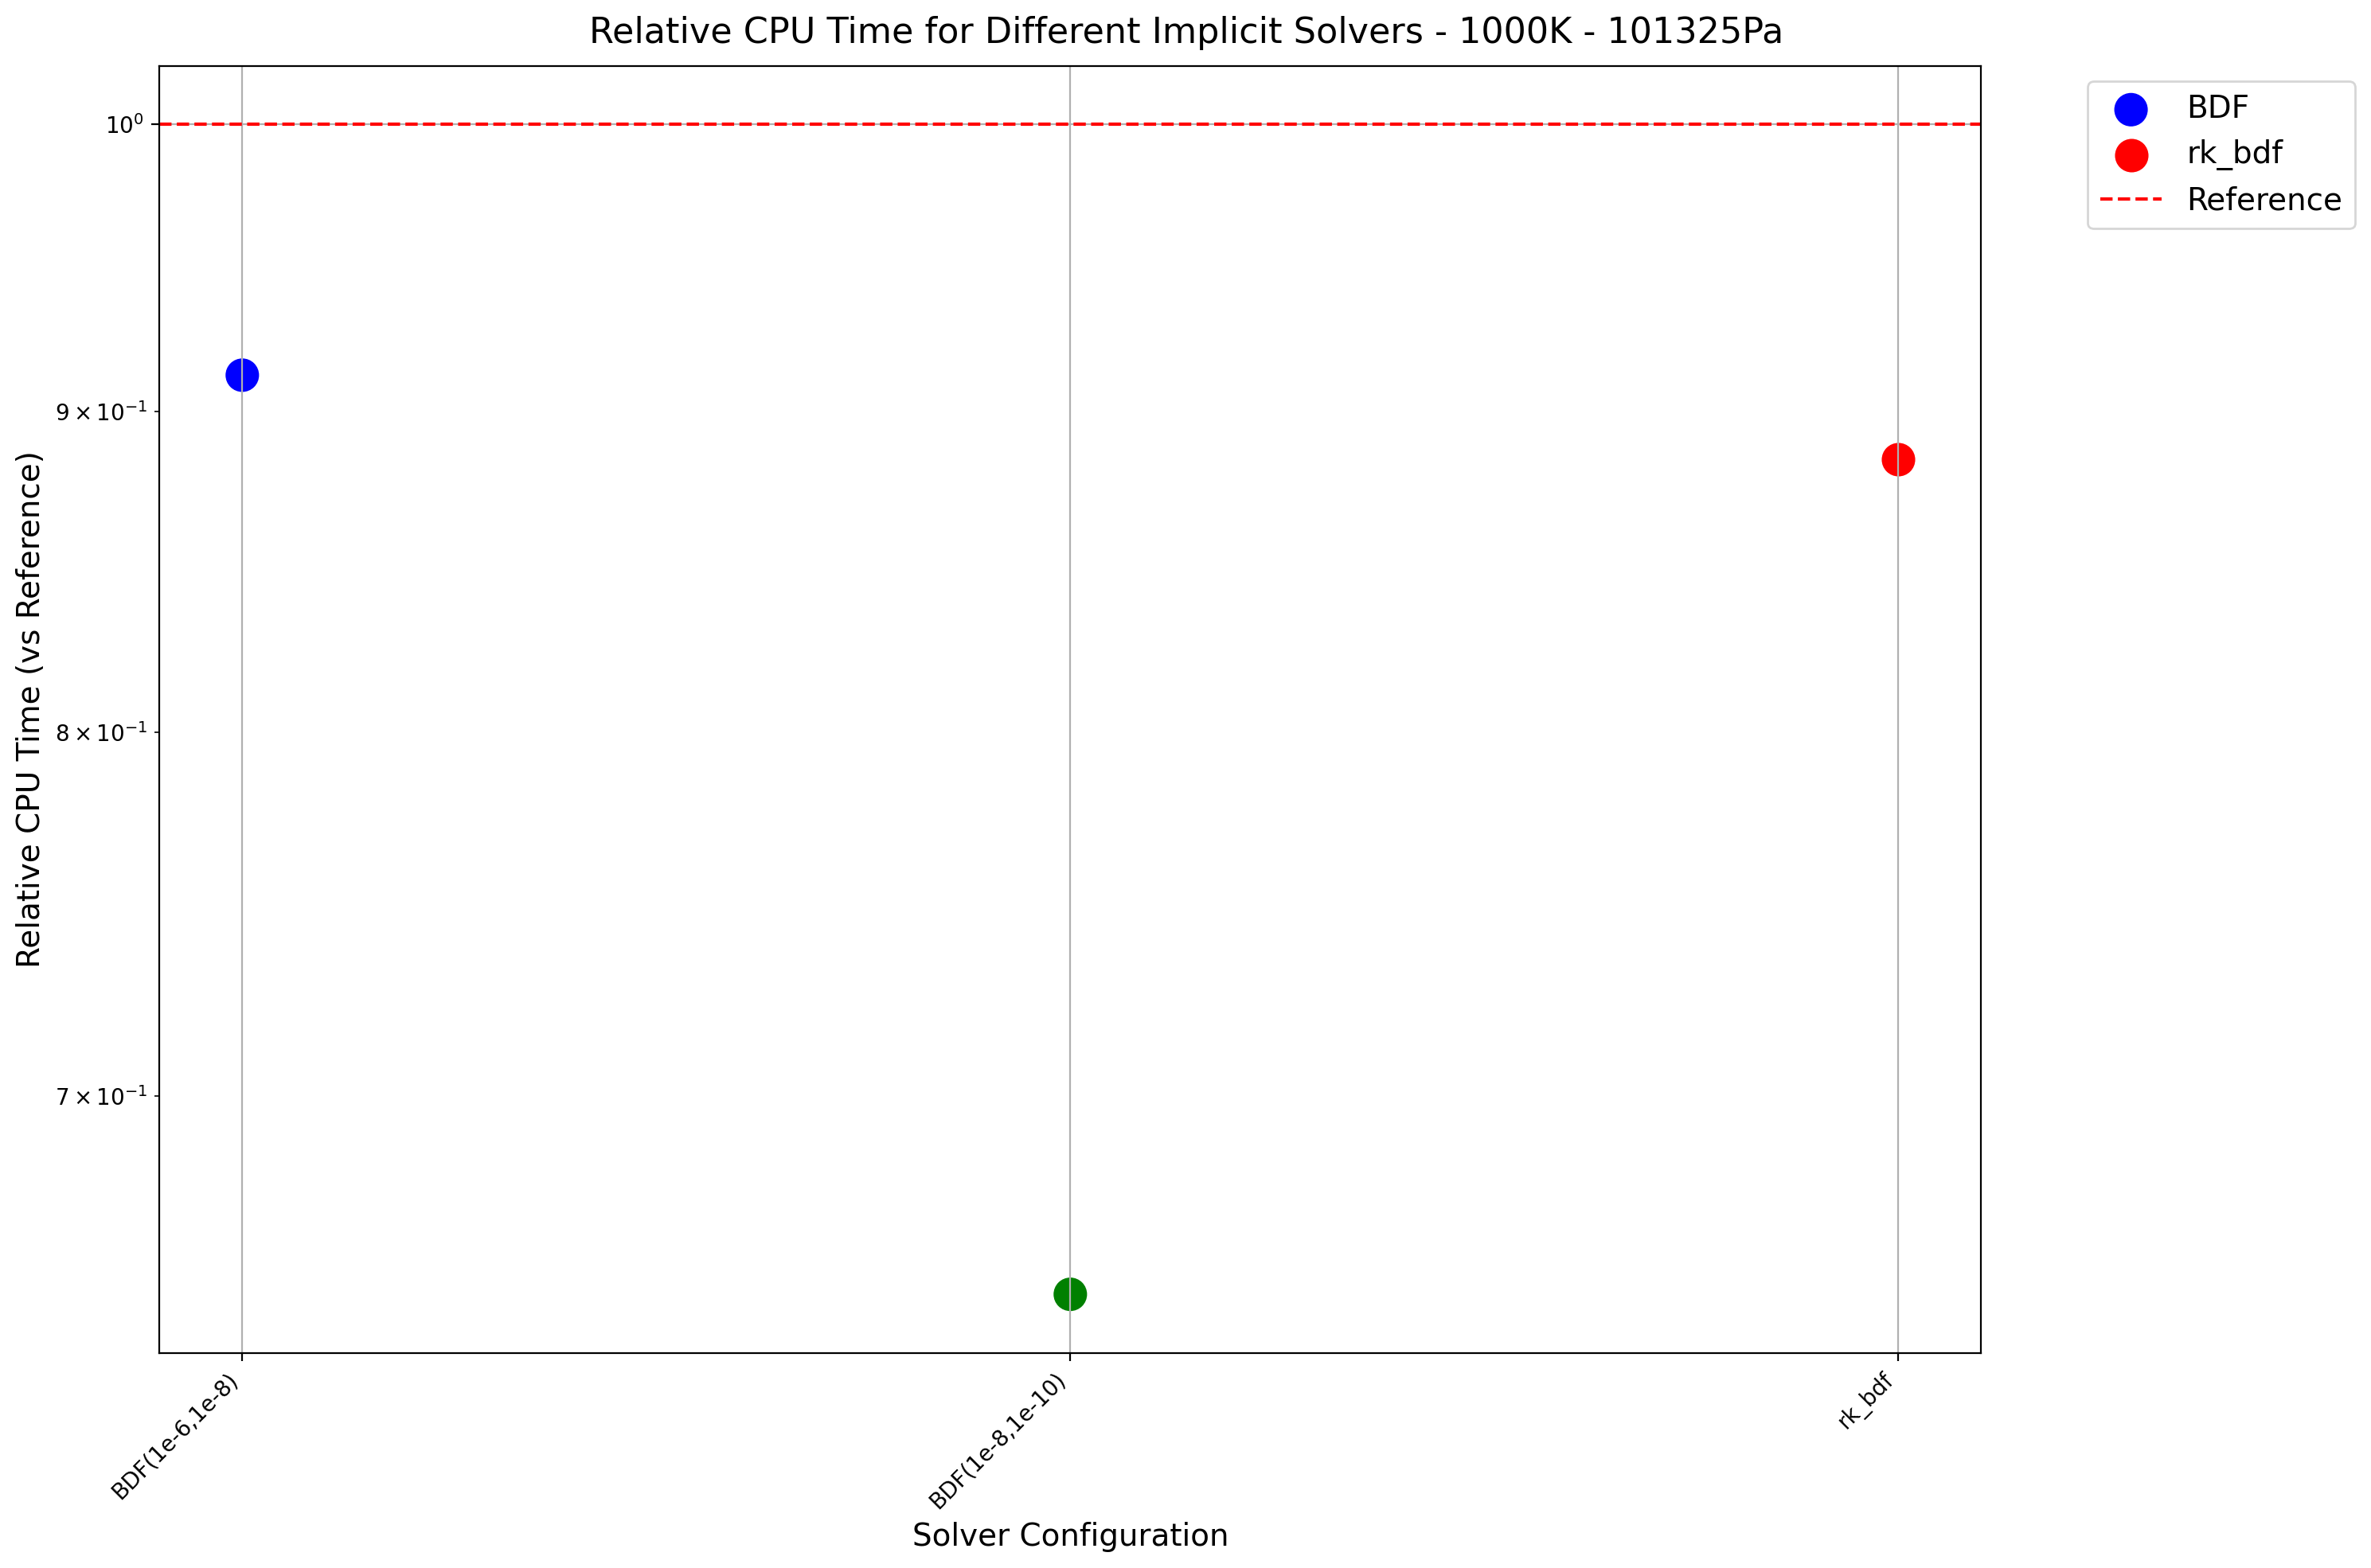

In [21]:

bdf_results_errors = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_low'], species_to_track, use_log=False)

bdf_results_errors_high = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_high'], species_to_track, use_log=False)


rk_bdf_results_errors = calculate_rmse(bdf_results['reference'], rk_bdf_results, species_to_track, use_log=False)


In [ ]:
# solver_errors = {}
# solver_errors_high = {}
# explicit_solver_errors = {}
# species_to_track = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
# for table_id in solver_to_run:
#     if len(solvers_results_low[table_id]['cpu_times']) < 100:
#         continue
#     solver_errors[table_id] = calculate_rmse(bdf_results['reference'], solvers_results_low[table_id], species_to_track, use_log=False)
#     solver_errors_high[table_id] = calculate_rmse(bdf_results['reference'], solvers_results_high[table_id], species_to_track, use_log=False)


# bdf_results_errors = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_low'], species_to_track, use_log=False)

# bdf_results_errors_high = calculate_rmse(bdf_results['reference'], bdf_results['bdf_results_high'], species_to_track, use_log=False)



In [ ]:
solver_to_exclude = [SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.ARK324L2SA_ERK_4_2_3, SP.arkode.ButcherTable.ARK437L2SA_DIRK_7_3_4, SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3, SP.arkode.ButcherTable.CASH_5_3_4, SP.arkode.ButcherTable.HEUN_EULER_2_1_2]


In [ ]:
solver_to_plot = [SP.arkode.ButcherTable.HEUN_EULER_2_1_2 , SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3, SP.arkode.ButcherTable.ARK2_DIRK_3_1_2, SP.arkode.ButcherTable.TRBDF2_3_3_2]

In [22]:
# Create one large figure with subplots for all species
fig, axes = plt.subplots(3, 3, figsize=(30, 30), dpi=300)

for i, specie_name in enumerate(species_to_track):
    ax = axes[i // 3, i % 3]
    ax.plot(running_average_forward(np.maximum(bdf_results_errors_high[specie_name], 1e-20), 1000),
            label=f"BDF(1e-8,1e-10)", 
            linestyle='-',
            linewidth=2,
                color='blue')
    ax.plot(running_average_forward(np.maximum(rk_bdf_results_errors[specie_name], 1e-20), 1000),
            label=f"rk_bdf", 
            linestyle='--',
            linewidth=2,
                color='red')
        
    ax.plot(running_average_forward(np.maximum(bdf_results_errors[specie_name], 1e-20), 1000),
            label=f"BDF(1e-6,1e-8)", 
            linestyle='-',
            linewidth=2,
                color='green')
    
    ax.set_title(f'{specie_name}')
    ax.set_yscale('log')
    ax.grid(True)
    if i == len(species_to_track) - 1:  # Only show legend on last plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

fig.suptitle('RMSE for Different Species Across All Implicit Solvers', fontsize=16)
plt.tight_layout()
plt.show()


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
# # Create one large figure with subplots for all species
# fig, axes = plt.subplots(3, 3, figsize=(30, 30), dpi=300)

# for i, specie_name in enumerate(species_to_track):
#     ax = axes[i // 3, i % 3]
#     ax.plot(running_average_forward(np.maximum(bdf_results_errors_high[specie_name], 1e-20), 1000),
#             label=f"BDF(1e-8,1e-10)", 
#             linestyle='-',
#             linewidth=2,
#                 color='blue')
#     for j, table_id in enumerate(solver_to_plot):
#         if len(solver_errors_high[table_id][specie_name]) < 100:
#             continue
#         data = solver_errors_high[table_id]
#         ax.plot(running_average_forward(np.maximum(data[specie_name], 1e-20), 1000),
#             label=f"{str(table_id)}", 
#             linestyle='--',
#             linewidth=2,
#                 color=colors[i])
        
#         data = solver_errors[table_id]
#         ax.plot(running_average_forward(np.maximum(data[specie_name], 1e-20), 1000),
#             label=f"{str(table_id)}", 
#             linestyle='-',
#             linewidth=2,
#                 color=colors[i])
        
#     ax.plot(running_average_forward(np.maximum(bdf_results_errors[specie_name], 1e-20), 1000),
#             label=f"BDF(1e-6,1e-8)", 
#             linestyle='-',
#             linewidth=2,
#                 color='red')
    
#     ax.set_title(f'{specie_name}')
#     ax.set_yscale('log')
#     ax.grid(True)
#     if i == len(species_to_track) - 1:  # Only show legend on last plot
#         ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

# fig.suptitle('RMSE for Different Species Across All Implicit Solvers', fontsize=16)
# plt.tight_layout()
# plt.show()


In [ ]:
solver_to_run = solver_to_plot

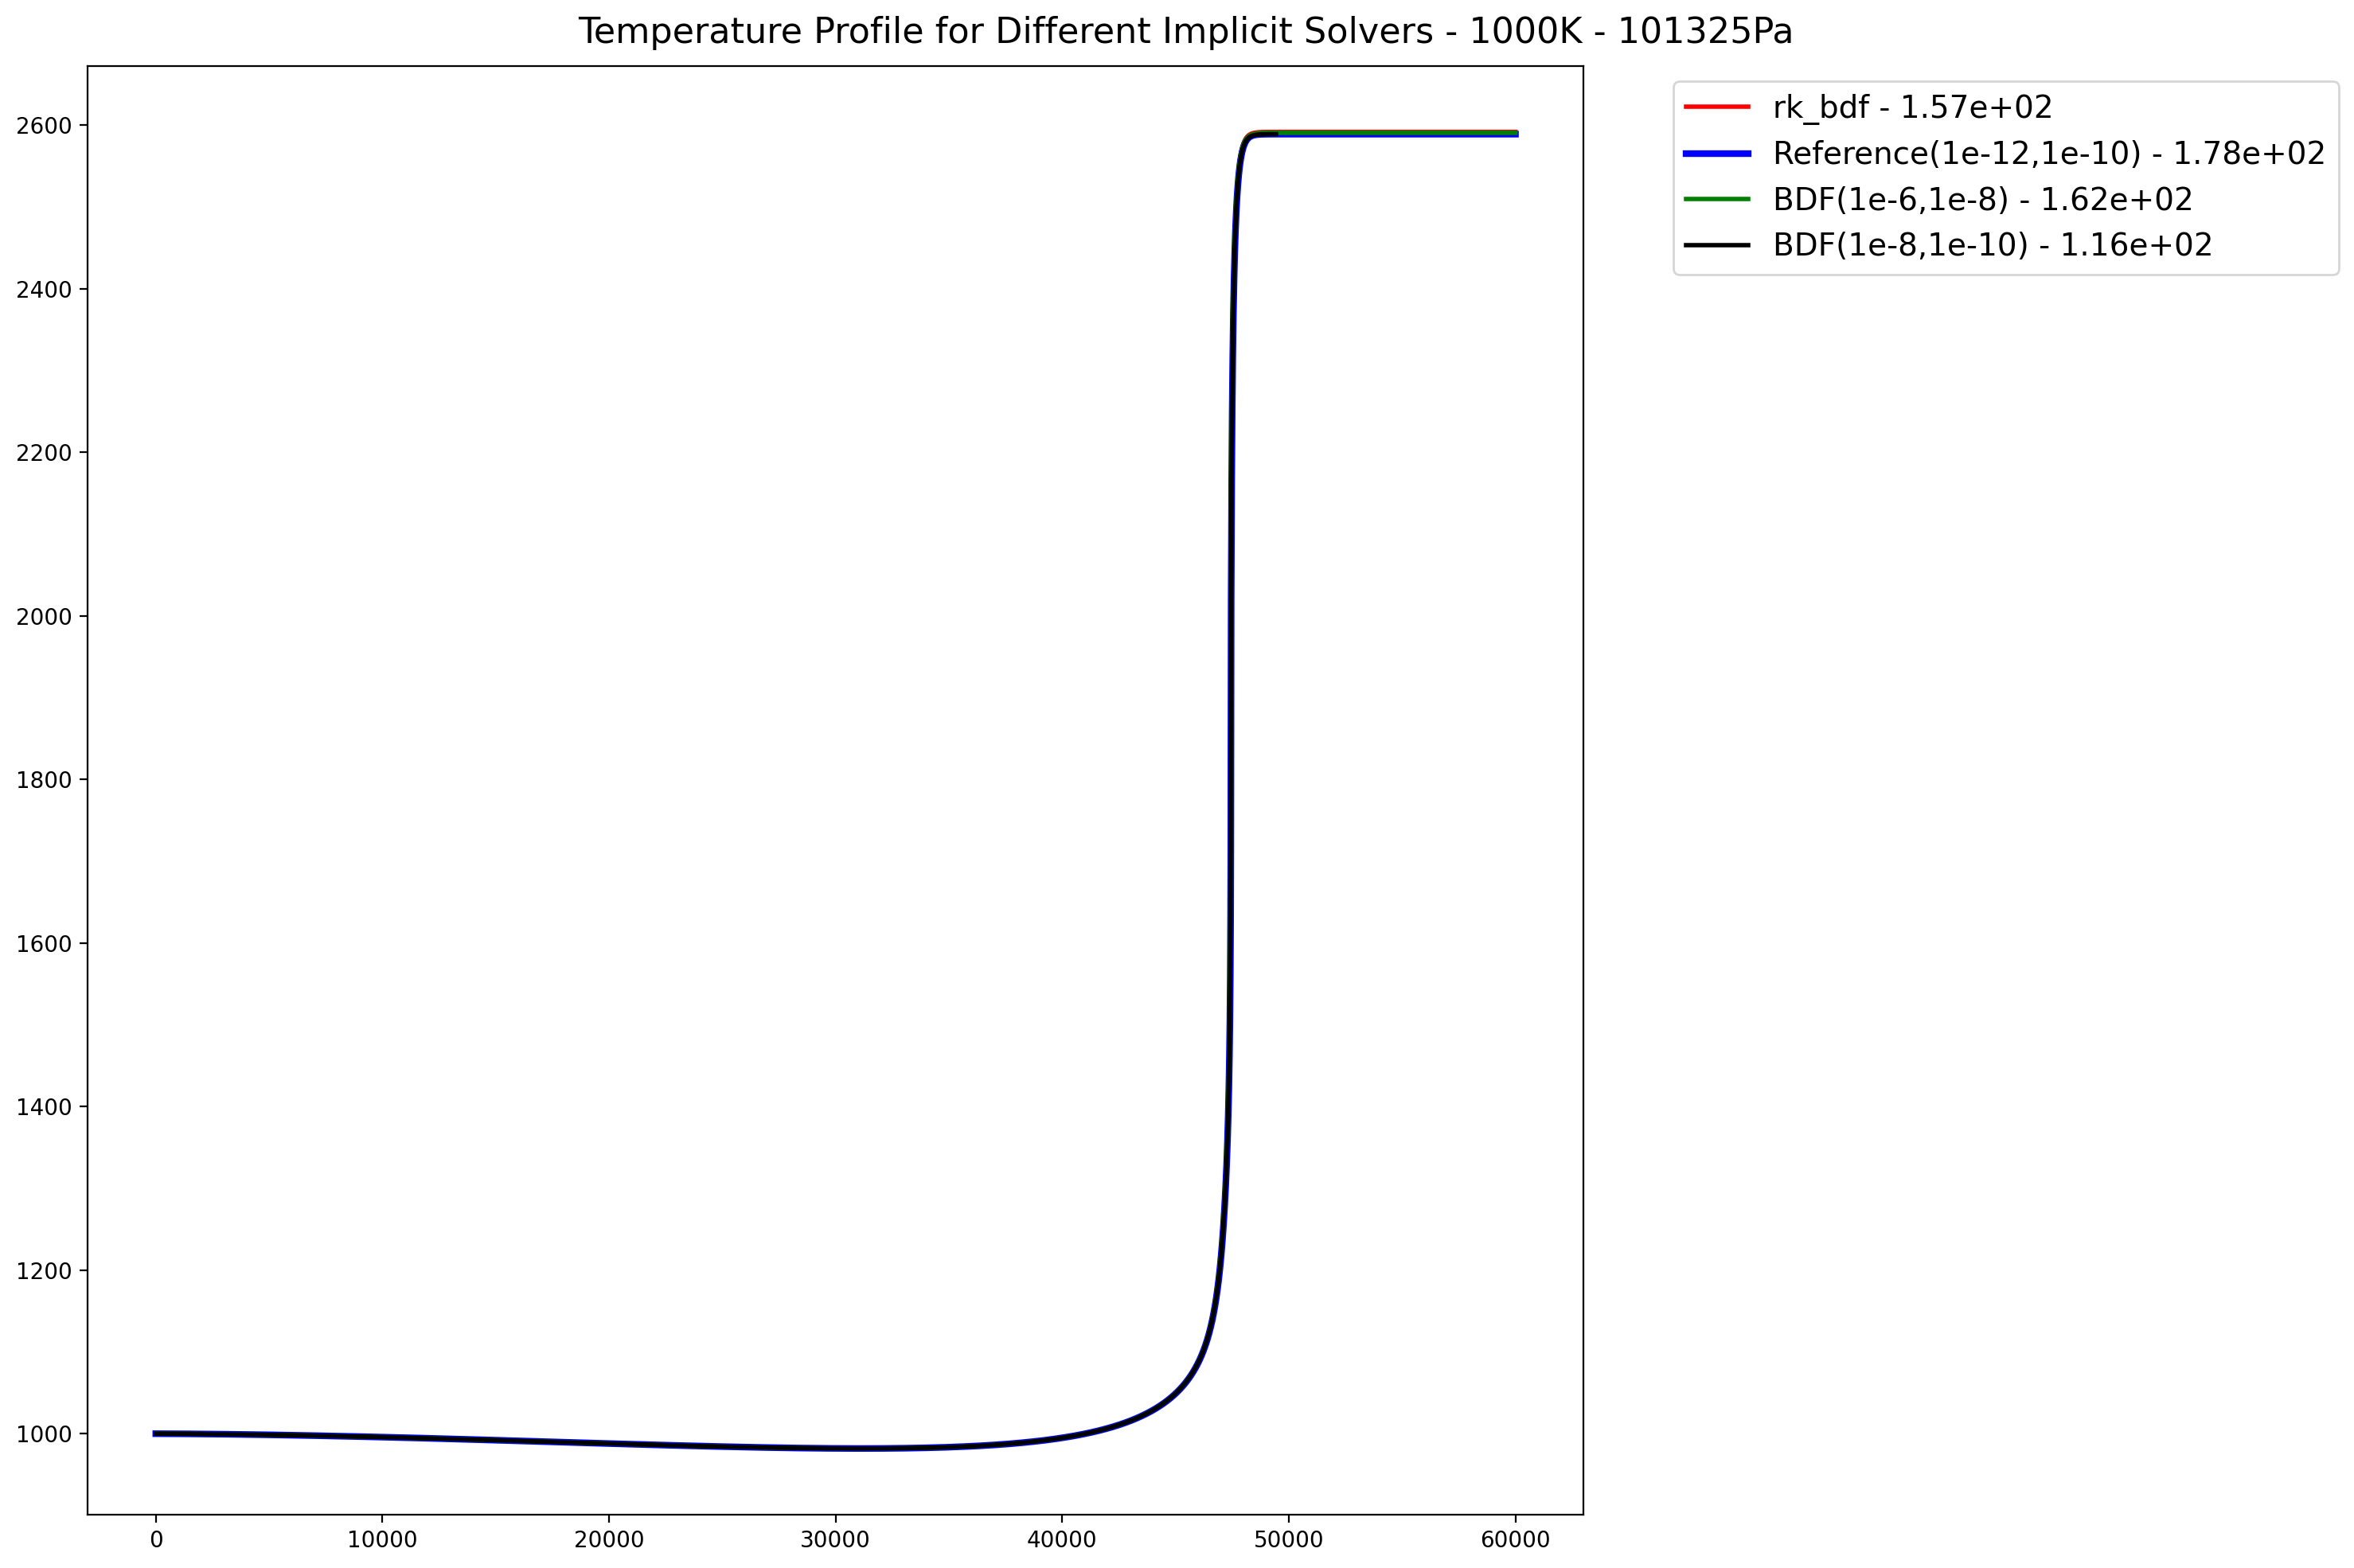

In [ ]:
# def calculate_maximum_species_conc(data, ref_data, species_name):
#     max_concentrations = {}
#     for specie in species_name:
#         if specie == 'temperature':
#             max_conc = np.mean(data['temperatures'])
#             ref_max_conc = np.mean(ref_data['temperatures'])
#         else:
#             max_conc = np.mean(data['species_profiles'][specie])
#             ref_max_conc = np.mean(ref_data['species_profiles'][specie])
#         max_concentrations[specie] = (max_conc, ref_max_conc)
#     return max_concentrations

# solver_max_conc = {}
# solver_max_conc_high = {}

# species_to_track = ['temperature', 'h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
# for table_id in solver_to_run:
#     if len(solvers_results_low[table_id]['cpu_times']) < 100:
#         continue
#     solver_max_conc[table_id] = calculate_maximum_species_conc(solvers_results_low[table_id], bdf_results['reference'], species_to_track)
#     solver_max_conc_high[table_id] = calculate_maximum_species_conc(solvers_results_high[table_id], bdf_results['reference'], species_to_track)


# bdf_max_conc = calculate_maximum_species_conc(bdf_results['reference'], bdf_results['bdf_results_low'], species_to_track)

# bdf_max_conc_high = calculate_maximum_species_conc(bdf_results['reference'], bdf_results['bdf_results_high'], species_to_track)





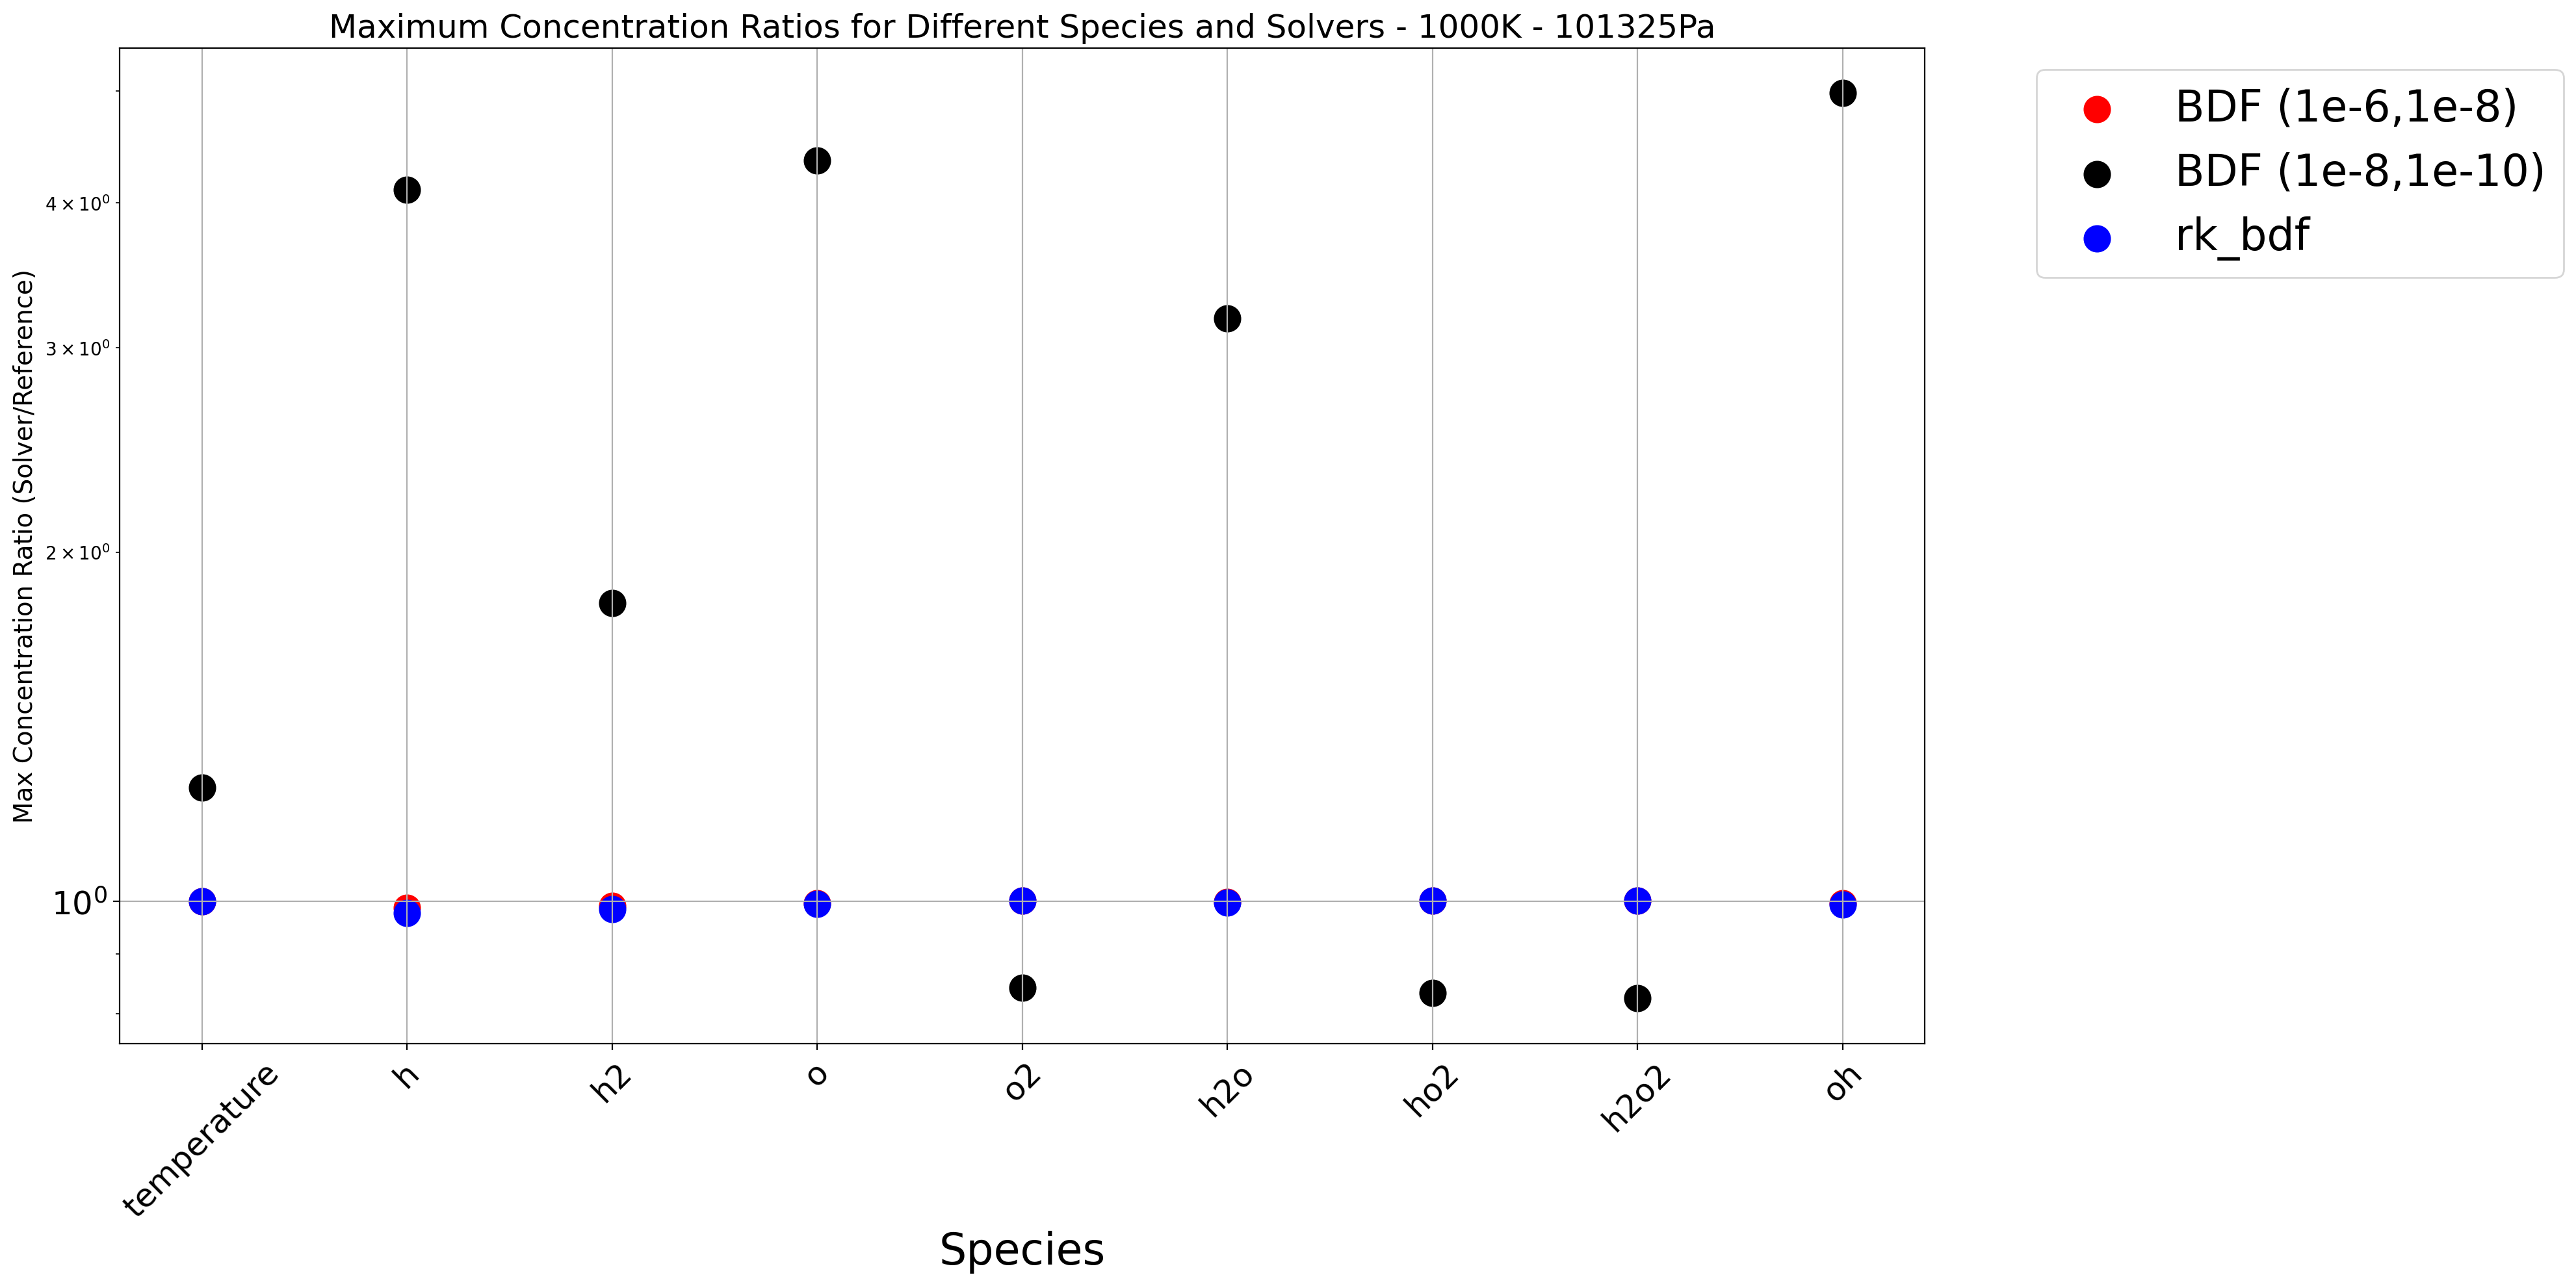

In [38]:
# Create a figure for plotting max concentration ratios
fig, ax = plt.subplots(figsize=(20, 10), dpi=200)

# Track x-axis positions and labels
x_positions = []
x_labels = []
current_x = 0
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'navy', 'gray', 'olive', 'maroon', 'gold', 'silver', 'indigo', 'turquoise']
# Plot for each species

for specie_name in species_to_plot:
    # Plot BDF results
    bdf_ratio_low = bdf_max_conc[specie_name][0] / bdf_max_conc[specie_name][1]
    bdf_ratio_high = bdf_max_conc_high[specie_name][0] / bdf_max_conc_high[specie_name][1]
    
    ax.scatter(current_x, bdf_ratio_low, color='red', s=200, label='BDF (1e-6,1e-8)' if specie_name == species_to_track[0] else "")
    ax.scatter(current_x, bdf_ratio_high, color='black', s=200, label='BDF (1e-8,1e-10)' if specie_name == species_to_track[0] else "")
    
    # Plot other solver results
    rk_bdf_ratio = rk_bdf_max_conc[specie_name][0] / rk_bdf_max_conc[specie_name][1]
        
    ax.scatter(current_x, rk_bdf_ratio, color='blue', s=200, 
              label=f"rk_bdf" if specie_name == species_to_track[0] else "")
    
    x_positions.append(current_x)
    x_labels.append(specie_name)
    current_x += 1
# Customize plot
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, fontsize=24)
ax.set_xlabel('Species', fontsize=24)
# ax.set_yticklabels([f'{i:.2e}' for i in ax.get_yticks()], fontsize=24)
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Max Concentration Ratio (Solver/Reference)', fontsize=14)
ax.set_title(f'Maximum Concentration Ratios for Different Species and Solvers - {temperature}K - {pressure}Pa', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.show()
